# Silverbox

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a set of measurements of an electronic implementation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation).

State-space model of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed:

$$\begin{align}
w(t) =&\ \frac{d B(t)}{dt} \sim \mathcal{N}(0, \tau^{-1}dt)
\end{align}$$

The parameter $\tau$ represents the precision of the process. The same holds for the measurement noise.

## Solution steps

### 1. Ignore nonlinear stiffness

For now, we ignore the nonlinear stiffness component by setting the parameter $b$ to 0. The state transition thus reduces to:

$$\begin{align}
m x''(t) + v x'(t) + a x(t) = u(t) + w(t) 
\end{align}$$

### 2. Discretize using finite-differences

I'm using an implicit method, for stability reasons.
The backward difference for both derivative terms:

$$\begin{align}
x''(t) \approx&\ \frac{x(t) - 2x(t-h) + x(t-2h)}{h^2} = \frac{x_t - 2x_{t-1} + x_{t-2}}{(\Delta t)^2}\\
x'(t) \approx&\ \frac{x(t) - x(t-h)}{h} = \frac{x_t - x_{t-1}}{\Delta t}\\
\end{align}$$

where $\Delta t = t - (t-1) = 1$. A discretization of the Wiener process yields:

$$\begin{align}
w(t) = \frac{dB(t)}{dt} \approx \frac{B(t) - B(t-h)}{h} = \frac{B_t - B_{t-1}}{\Delta t} \sim \mathcal{N}(0, \tau^{-1}\Delta t) \, .
\end{align}$$

Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The control signal $u(t)$ was constructed from a discrete signal, converted into an analogue signal through a zero-order-hold filter. That means it's a step-function: constant between any $t$ and $t-1$. Since it is an observed variable, we can just convert $u(t)$ straight to $u_t$. The DE can now be written as the following discrete-time system:

$$m (x_t - 2x_{t-1} + x_{t-2}) + v (x_t - x_{t-1}) + a x_t = u_t + w_t$$

Re-writing this in terms of $x_t$ yields:
$$\begin{align}
(m + v + a) x_t&\ + (-2m - v) x_{t-1} + m x_{t-2} = u_t + w_t \\
% x_t + \frac{-2m - v}{m + v + a} x_{t-1} + \frac{m}{m + v + a} x_{t-2} =&\ \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \\
x_t&\ = \frac{2m + v}{m + v + a} x_{t-1} + \frac{-m}{m + v + a} x_{t-2} + \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \, .
\end{align}$$


### 3. Substitute variables:

I'm substituting variables to clean the equation up a bit:

$$\begin{align} 
\theta_1 =&\ \frac{2m + v}{m + v + a} \\
\theta_2 =&\ \frac{-m}{m + v + a} \\
\eta =&\ \frac{1}{m + v + a} \, .
\end{align}$$

This produces:
$$\begin{align}
x_t = \theta_1 x_{t-1} + \theta_2 x_{t-2} + \eta u_t + \eta w_t
\end{align}$$

I'm going to absorb $\eta$ into $w_t$ (using $\mathbb{V}[aX] = a^2\mathbb{V}[X]$):

$$\begin{align}
\mathbb{V}[\eta w_t] = \eta^2 \mathbb{V}[w_t] = \eta^2 \tau^{-1}
\end{align}$$

I will rename $\eta^2 \tau^{-1}$ as $\gamma^{-1}$. This yields

$$\begin{align}
x_t = \theta_1 x_{t-1} + \theta_2 x_{t-2} + \eta u_t + \tilde{w}_t
\end{align}$$

where $\tilde{w}_t \sim \mathcal{N}(0, \gamma^{-1})$. Given four equations and four unknowns, I can recover $m$, $v$, $a$ and $\tau$ from $\theta_1$, $\theta_2$, $\eta$ and $\gamma$.

### 4. Cast to multivariate first-order form

The system now resembles an auto-regressive process:

$$ \underbrace{\begin{bmatrix} x_t \\ x_{t-1} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} \theta_1 & \theta_2 \\ 1 & 0 \end{bmatrix}}_{A(\theta)} \underbrace{\begin{bmatrix} x_{t-1} \\ x_{t-2} \end{bmatrix}}_{z_{t-1}} + \underbrace{\begin{bmatrix} \eta \\ 0 \end{bmatrix}}_{B(\eta)} u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, .$$

Note that we need a two-dimensional state prior now (reminiscent of adding an initial condition on the velocity).

### 5. Convert to Gaussian probability

The state transition maps to

$$z_t \sim \mathcal{N}(A(\theta) z_{t-1} + c\eta u_t, V)$$

where $V = \begin{bmatrix} \gamma^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $V^{-1} = W = \begin{bmatrix} \gamma & 0 \\ 0 & \epsilon^{-1} \end{bmatrix}$.

The observation likelihood maps to

$$y_t \sim \mathcal{N}(c^{\top} z_t, \xi^{-1})$$

where $c = \begin{bmatrix} 1 & 0 \end{bmatrix}$ and $e_t \sim \mathcal{N}(0, \xi^{-1})$.

### 6. Choose priors

We currently have unknown parameters $\psi = (\theta_1, \theta_2, \eta, \gamma)$. Since they are substitutions, we don't know anything about their support directly. We do know about it indirectly, from the nonlinear combinations of the physical coefficients. We know that mass $m$ and process precision $\gamma$ are strictly positive parameters and that the damping and stiffness coefficients can be both positive and negative. Hence, by examing the nonlinear transform $\psi = G(\phi)$;

$$\begin{align} 
\theta_1 =&\ \frac{2m + v}{m + v + a} \\
\theta_2 =&\ \frac{-m}{m + v + a} \\
\eta =&\ \frac{1}{m + v + a} \\
\gamma^{-1} =&\ \frac{1}{\tau(m + v+ a)^2} \, .
\end{align}$$

we realize that $\theta_1$, $\theta_2$ and $\eta$ can be both positive and negative, but $\gamma$ can only be positive. As such, we choose the following priors:

$$\begin{align}
\theta \sim&\ \mathcal{N}(m^{0}_{\theta}, V^{0}_{\theta}) \\
\eta \sim&\ \mathcal{N}(m^{0}_{\eta}, v^{0}_{\eta}) \\ 
\gamma \sim&\ \Gamma(a^{0}_\gamma, b^{0}_\gamma) 
\end{align}$$

Modeling $\theta = (\theta_1, \theta_2)$ as a joint Gaussian allows for incorporating it into an Autoregressive node.

### 7. Recover physical variables from substituted ones

Since we have four equations and four unknowns, we can perfectly recover point estimates of the physical variables from substituted ones. However, we don't want point estimates, we want posteriors. 

If we approximate $\gamma$ with a log-Normal distribution and then map it to a Gaussian distribution (i.e. model $\log(\gamma)$), we end up with a Gaussian distributed random vector $\psi = [\theta_1, \theta_2, \eta, \log(\gamma)]$. We can perform a Gaussian approximation of the inverse mapping $G^{-1}(\psi)$ using a first-order Taylor expansion:

$$\begin{align}
m_{\phi} \triangleq \mathbb{E}[G^{-1}(\psi)] =&\ G^{-1}(m_{\psi} \\
V_{\phi} \triangleq \mathbb{V}[G^{-1}(\psi)] =&\ J_{\psi}(m_{\psi}) G^{-1}(m_{\psi} J_{\psi}(m_{\psi})^{\top} \, ,
\end{align}$$

Since each component of $\phi$ is Gaussian distributed, we have actually modeled $\log(m)$ and $\log(\tau)$. We still need to map these to log-Normal distributions to recover $m$ and $\tau$.

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots
viz = false;

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
# Plot every n-th time-point to avoid figure size exploding
n = 10;

In [5]:
# Plot output signal (observed displacement)
if viz  
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
    # Plots.savefig(p1, "viz/output_signal.png")
end

In [6]:
# Plot input signal (control)
if viz
    p2 = Plots.scatter(1:n:T, input[1:n:T], color="blue", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="control")
    # Plots.savefig(p2, "viz/input_signal.png")
end

## Estimating parameters via Bayesian filtering

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode).

In [18]:
using LinearAlgebra
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using LAR
using LAR.Node
using ProgressMeter

In [19]:
using Zygote

function Jacobian(F, x)
    y = F(x)
    n = length(y)
    m = length(x)
    T = eltype(y)
    j = Array{T, 2}(undef, n, m)
    for i in 1:n
        j[i, :] .= gradient(x -> F(x)[i], x)[1]
    end
    return j
end;

In [39]:
# Start graph
graph = FactorGraph()

# Coefficients
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))
@RV u_t

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Add control
@RV x_u = z_t + η*u_t*[1., 0.]

# Autoregressive node
@RV x_t ~ Autoregressive(θ, x_u, γ, id=:x_t)

# Emission function
# @RV x_1 = dot([1., 0.], x_t)
# x_1.id = :x_1

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(x_t, ξ, id=:y_t)

# Placeholders
placeholder(y_t, :y_t)
placeholder(u_t, :u_t)

# Draw time-slice subgraph
# ForneyLab.draw(graph)

# Inference algorithm
q = PosteriorFactorization([x_t, z_t], θ, η, γ, ξ, ids=[:x_t, :θ, :η, :γ, :ξ])
algo = variationalAlgorithm(q, free_energy=true)
source_code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(source_code));
# println(source_code)

ErrorException: No applicable marginal update rule for Autoregressive node with inbound types: Message{GaussianMeanPrecision,var_type} where var_type<:ForneyLab.VariateType, ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution

In [10]:
# Looking at only the first few timepoints
# T = 100
T = size(df, 1);

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_θ = (ones(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_η = (ones(1,T+1), .1*ones(1,T+1))
params_γ = (ones(1,T+1), ones(1,T+1))
params_ξ = (1e2*ones(1,T+1), 1e0*ones(1,T+1))

# Initialize physical coefficient estimate arrays
params_m = (zeros(T,), zeros(T,))
params_v = (zeros(T,), zeros(T,))
params_a = (zeros(T,), zeros(T,))
params_τ = (zeros(T,), zeros(T,))


# Start progress bar
p = Progress(T, 1, "At time ")

# Perform inference at each time-step
for t = 1:T

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:x_u] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t], b=params_ξ[2][1,t])
    
    # Set clamped variables
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_x[1][:,t],
                :w_z => params_x[2][:,:,t],
                :m_θ => params_θ[1][:,t],
                :w_θ => params_θ[2][:,:,t],
                :m_η => params_η[1][1,t],
                :w_η => params_η[2][1,t],
                :a_γ => params_γ[1][1,t],
                :b_γ => params_γ[2][1,t],
                :a_ξ => params_ξ[1][1,t],
                :b_ξ => params_ξ[2][1,t])
    
    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepγ!(data, marginals)
        stepξ!(data, marginals)
    end
    
    # Store current parameterizations of marginals
    params_x[1][:,t+1] = mean(marginals[:x_t])
    params_x[2][:,:,t+1] = marginals[:x_t].params[:w]
    params_θ[1][:,t+1] = mean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[1][1,t+1] = mean(marginals[:η])
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_γ[1][1,t+1] = marginals[:γ].params[:a]
    params_γ[2][1,t+1] = marginals[:γ].params[:b]
    params_ξ[1][1,t+1] = marginals[:ξ].params[:a]
    params_ξ[2][1,t+1] = marginals[:ξ].params[:b]
    
    "Map substituted to physical variables via first-order Taylor"
    
    # Approximate gamma with log-normal via moment-matching
    Eγ = unsafeMean(marginals[:γ])
    Vγ = unsafeVar(marginals[:γ])
    m_γ = log(Eγ^2/sqrt(Vγ + Eγ^2))
    v_γ = log(Vγ/Eγ^2 + 1)

    # Construct vector of parameter estimates ψ
    m_ψ = [unsafeMean(marginals[:θ])[1], unsafeMean(marginals[:θ])[2], unsafeMean(marginals[:η])[1], m_γ]
#     V_ψ = unsafeCov(marginals[:θ])Diagonal([var(marginals[:θ])[1], var(marginals[:θ])[2], var(marginals[:η])[1], v_γ])
    V_ψ = [unsafeCov(marginals[:θ]) zeros(2,2); zeros(2,2) [unsafeCov(marginals[:η])[1,1] 0;0 v_γ]]

    # Transformation: ψ = G(ϕ) => ϕ = G_inv(ψ)
    G_inv(ψ) = [-ψ[2]/ψ[3], (ψ[1] + 2*ψ[2])/ψ[3], (-ψ[1] -ψ[2] +1)/ψ[3], ψ[4]/ψ[3]^2]
    
    # Compute Jacobian of transformation 
    J_mϕ = Jacobian(G_inv, m_ψ)
    
    # Compute moments of transformed Gaussian using first-order Taylor approx
    m_ϕ = G_inv(m_ψ)
    V_ϕ = J_mϕ*V_ψ*J_mϕ'

    # Split ϕ into physical coefficients
    m_m, m_v, m_a, m_τ = m_ϕ
    v_m, v_v, v_a, v_τ = Diagonal(V_ϕ)
    
    # Store param estimates for mass
    params_m[1][t] = m_m
    params_m[2][t] = v_m
    
    # Store param estimates for friction
    params_v[1][t] = m_v
    params_v[2][t] = v_v
    
    # Store param estimates for linear stiffness
    params_a[1][t] = m_a
    params_a[2][t] = v_a
    
    # Store param estimates for process precision
    params_τ[1][t] = m_τ
    params_τ[2][t] = v_τ

end

UndefVarError: UndefVarError: stepx! not defined

### Visualize results

In [11]:
# Plot every n-th time-point to avoid large figure filesizes
n = 20;

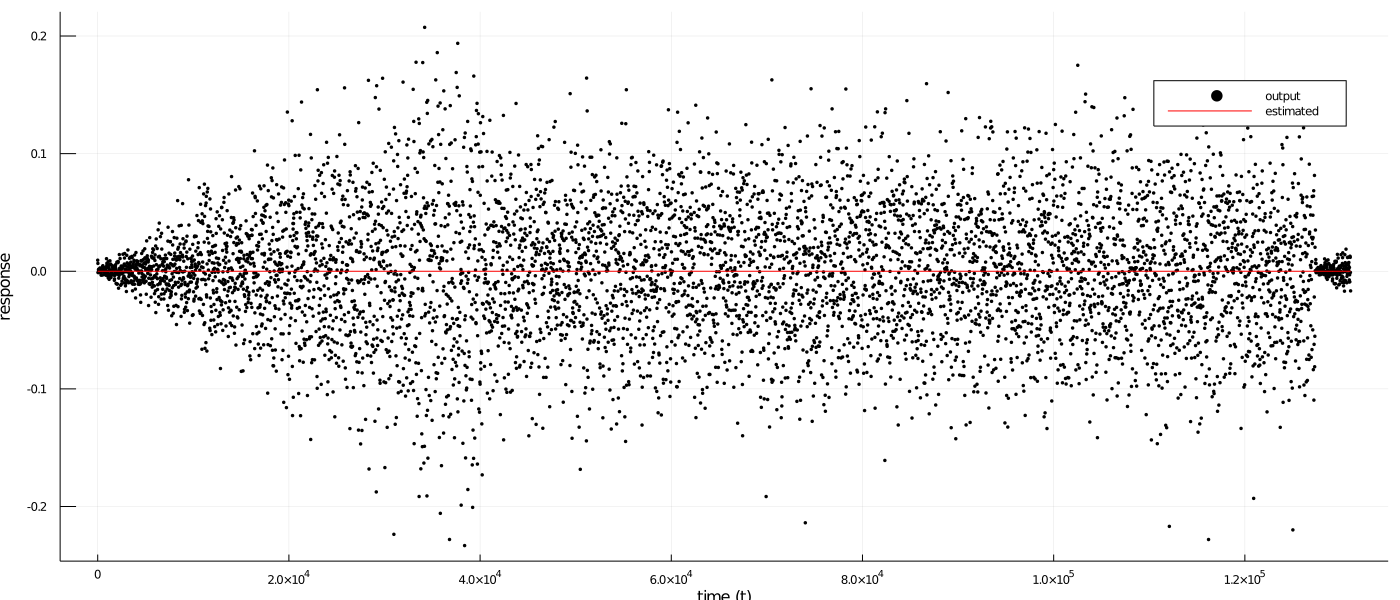

In [12]:
# Plot estimated states
p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1400,600), xlabel="time (t)", ylabel="response")
Plots.plot!(1:n:T, params_x[1][1,2:n:end], color="red", linewidth=1, label="estimated")
# Plots.savefig(p1, "viz/estimated_states01.png")

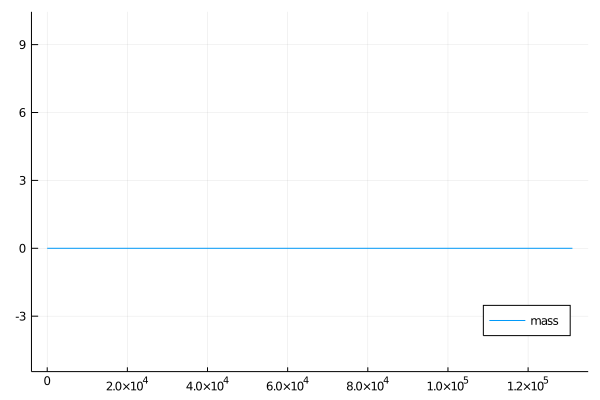

In [13]:
# Visualize estimates of mass
plot(1:n:T, params_m[1][2:n:T], ribbon=[sqrt.(params_m[2][2:n:T]) sqrt.(params_m[2][2:n:T])], label="mass", legend=:bottomright, ylim=[-5.,10.])

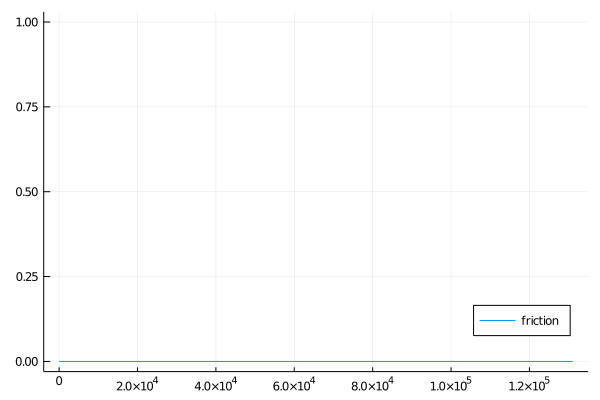

In [14]:
# Visualize estimates of friction
plot(1:n:T, params_v[1][1:n:T], ribbon=[sqrt.(params_v[2][1:n:T]) sqrt.(params_v[2][1:n:T])], label="friction", legend=:bottomright)

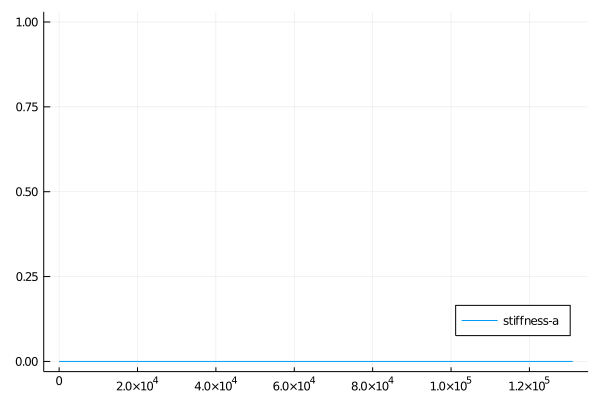

In [15]:
# Visualize estimates of linear stiffness
plot(1:n:T, params_a[1][1:n:T], ribbon=[sqrt.(params_a[2][1:n:T]) sqrt.(params_a[2][1:n:T])], label="stiffness-a", legend=:bottomright)

In [16]:
# Visualize estimates of process noise
plot(1:n:T, params_τ[1][1:n:T], ribbon=[sqrt.(params_τ[2][1:n:T]) sqrt.(params_τ[2][1:n:T])], label="process-noise", legend=:bottomright, yscale=:log10)

┌ Warning: No strict ticks found
└ @ PlotUtils /home/wmkouw/.julia/packages/PlotUtils/nCtbM/src/ticks.jl:283


ArgumentError: ArgumentError: At least one finite value must be provided to formatter.

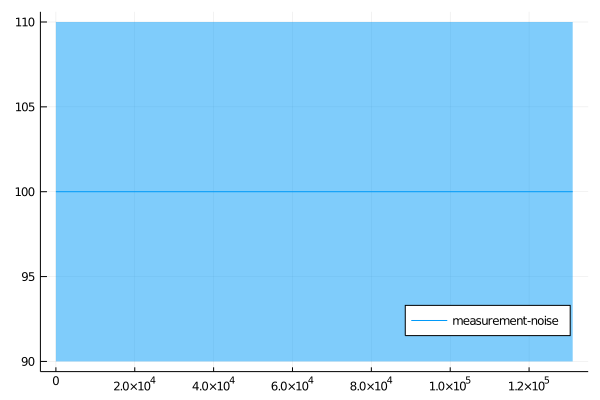

In [17]:
# Visualize estimates of measurement noise
mean_ξ_inv = params_ξ[1] ./ params_ξ[2]
var_ξ_inv = params_ξ[1] ./ params_ξ[2].^2
plot(1:n:T, mean_ξ_inv[1:n:T], ribbon=[sqrt.(var_ξ_inv[1:n:T]) sqrt.(var_ξ_inv[1:n:T])], label="measurement-noise", legend=:bottomright)